<a href="https://colab.research.google.com/github/mizzony/AFL/blob/main/KIKI_AFL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')

#Explore the dataset
data.describe()
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GameId            2447 non-null   object 
 1   Year              2447 non-null   int64  
 2   Round             2447 non-null   object 
 3   Date              2447 non-null   object 
 4   MaxTemp           2440 non-null   float64
 5   MinTemp           2440 non-null   float64
 6   Rainfall          2425 non-null   float64
 7   Venue             2447 non-null   object 
 8   StartTime         2447 non-null   object 
 9   Attendance        2447 non-null   object 
 10  HomeTeam          2447 non-null   object 
 11  HomeTeamScoreQT   2447 non-null   float64
 12  HomeTeamScoreHT   2447 non-null   float64
 13  HomeTeamScore3QT  2447 non-null   float64
 14  HomeTeamScoreFT   2447 non-null   float64
 15  HomeTeamScore     2447 non-null   int64  
 16  AwayTeam          2447 non-null   object 


,GameId,Year,Round,Date,MaxTemp,MinTemp,Rainfall,Venue,StartTime,Attendance,...,HomeTeamScore3QT,HomeTeamScoreFT,HomeTeamScore,AwayTeam,AwayTeamScoreQT,AwayTeamScoreHT,AwayTeamScore3QT,AwayTeamScoreFT,AwayTeamScore,Win
0,2012R0101,2012,R1,2012-03-24,24.0,12.2,0.0,Stadium Australia,7:20 PM,"38,203",...,3.4,5.70,37,Sydney,4.1,8.4,13.80,14.16,100,0
1,2012R0102,2012,R1,2012-03-29,25.7,9.7,0.0,M.C.G.,7:45 PM,"78,285",...,10.7,12.90,81,Carlton,3.2,8.7,11.13,18.17,125,0
2,2012R0103,2012,R1,2012-03-30,27.4,9.7,0.0,M.C.G.,7:50 PM,"78,466",...,14.1,20.17,137,Collingwood,2.7,7.9,12.16,16.19,115,1
3,2012R0104,2012,R1,2012-03-31,29.1,15.1,0.6,M.C.G.,1:45 PM,"33,473",...,8.8,11.12,78,Brisbane Lions,1.4,7.8,13.13,17.17,119,0
4,2012R0105,2012,R1,2012-03-31,28.2,19.7,0.0,Carrara,3:45 PM,"12,790",...,8.6,10.80,68,Adelaide,7.8,11.1,15.16,19.23,137,0


In [ ]:
unique_teams = data['HomeTeam'].unique()
print(f'Unique Home Teams: {unique_teams}')
print(f'Count of Unique Home Teams: {len(unique_teams)}')

Unique Home Teams: ['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney' 'West Coast' 'Adelaide'
 'Collingwood' 'St Kilda' 'Geelong' 'Carlton']
Count of Unique Home Teams: 18


In [ ]:
# Calculate average attendance per venue
average_attendance = data.groupby('Venue')['Attendance'].mean().sort_values(ascending=False)

# Apply formatting to each value in the Series
formatted_attendance = average_attendance.apply(lambda x: f'{x:.2f} people')

# Print the formatted output
print("Average Attendance per Venue:")
print(formatted_attendance)

Average Attendance per Venue:
Venue
M.C.G.                51161.63 people
Perth Stadium         39923.99 people
Adelaide Oval         36695.59 people
Stadium Australia     36515.63 people
Subiaco               35468.57 people
Football Park         29707.35 people
S.C.G.                29310.96 people
Docklands             28193.67 people
Kardinia Park         22286.74 people
Gabba                 18681.04 people
Wellington            16026.67 people
York Park             12648.75 people
Manuka Oval           10351.82 people
Jiangwan Stadium      10073.00 people
Carrara                9857.43 people
Bellerive Oval         9736.61 people
Sydney Showground      9700.43 people
Norwood Oval           9193.00 people
Marrara Oval           8459.75 people
Eureka Stadium         7329.50 people
Summit Sports Park     7329.00 people
Riverway Stadium       7243.00 people
Blacktown              6875.00 people
Cazaly's Stadium       6834.92 people
Traeger Park           5170.44 people
Name: Attendan

In [ ]:
# Count wins and losses by year
win_counts = data.groupby(['Year'])['Win'].value_counts().unstack(fill_value=0)

# Rename the columns for clarity
win_counts.columns = ['Losses', 'Wins']

# Calculate total games played by year
win_counts['Total_Games'] = win_counts['Wins'] + win_counts['Losses']

# Display the results
print(win_counts)


      Losses  Wins  Total_Games
Year                           
2012      92   115          207
2013      92   115          207
2014      90   117          207
2015      98   108          206
2016      84   123          207
2017      86   121          207
2018      94   113          207
2019      89   118          207
2020      71    91          162
2021     100   107          207
2022      83   124          207
2023      92   124          216


In [ ]:
# Count wins by HomeTeam and total scores
home_wins_scores = data.groupby('HomeTeam').agg({'Win': 'sum', 'HomeTeamScore': 'sum'}).reset_index()
home_wins_scores.columns = ['Team', 'Total_Wins_Home', 'Total_Score_Home']

# Count wins by AwayTeam and total scores
away_wins_scores = data.groupby('AwayTeam').agg({'Win': 'sum', 'AwayTeamScore': 'sum'}).reset_index()
away_wins_scores.columns = ['Team', 'Total_Wins_Away', 'Total_Score_Away']

# Merge the home and away wins and scores
total_wins_scores = pd.merge(home_wins_scores, away_wins_scores, on='Team', how='outer')

# Fill NaN values with 0 and calculate total wins and scores
total_wins_scores.fillna(0, inplace=True)
total_wins_scores['Total_Wins'] = total_wins_scores['Total_Wins_Home'] + total_wins_scores['Total_Wins_Away']
total_wins_scores['Total_Score'] = total_wins_scores['Total_Score_Home'] + total_wins_scores['Total_Score_Away']

# Sort the DataFrame by 'Total_Wins' in descending order
total_wins_scores = total_wins_scores.sort_values(by='Total_Wins', ascending=False)

# Display the total wins and total scores by team in descending order
print(total_wins_scores[['Team', 'Total_Wins', 'Total_Score']])


                      Team  Total_Wins  Total_Score
6                  Geelong         179        26121
1           Brisbane Lions         165        22962
9                 Hawthorn         164        25567
16              West Coast         164        23602
5                Fremantle         161        21046
13                Richmond         159        24169
7               Gold Coast         158        19306
0                 Adelaide         156        24633
8   Greater Western Sydney         153        22377
12           Port Adelaide         152        23705
11         North Melbourne         149        22415
17        Western Bulldogs         147        22583
4                 Essendon         145        21550
15                  Sydney         145        25290
14                St Kilda         144        20876
3              Collingwood         139        23584
2                  Carlton         138        20674
10               Melbourne         134        21621


In [ ]:
# Count wins and total games by HomeTeam and total scores
home_stats = data.groupby('HomeTeam').agg({'Win': 'sum', 'HomeTeamScore': 'sum', 'GameId': 'count'}).reset_index()
home_stats.columns = ['Team', 'Total_Wins_Home', 'Total_Score_Home', 'Total_Games_Home']

# Count wins and total games by AwayTeam and total scores
away_stats = data.groupby('AwayTeam').agg({'Win': 'sum', 'AwayTeamScore': 'sum', 'GameId': 'count'}).reset_index()
away_stats.columns = ['Team', 'Total_Wins_Away', 'Total_Score_Away', 'Total_Games_Away']

# Merge the home and away stats
total_stats = pd.merge(home_stats, away_stats, on='Team', how='outer')

# Fill NaN values with 0
total_stats.fillna(0, inplace=True)

# Calculate total wins, scores, and games
total_stats['Total_Wins'] = total_stats['Total_Wins_Home'] + total_stats['Total_Wins_Away']
total_stats['Total_Score'] = total_stats['Total_Score_Home'] + total_stats['Total_Score_Away']
total_stats['Total_Games'] = total_stats['Total_Games_Home'] + total_stats['Total_Games_Away']

# Calculate average scores per game
total_stats['ATPG'] = total_stats['Total_Score'] / total_stats['Total_Games']
total_stats['ATPG'].fillna(0, inplace=True)  # Handle division by zero

# Sort the DataFrame by 'Total_Wins' in descending order
total_stats = total_stats.sort_values(by='Total_Wins', ascending=False)

# Display the total wins, total scores, total games, and average scores per game by team in descending order
print(total_stats[['Team', 'Total_Wins', 'Total_Score', 'Total_Games', 'ATPG']])


                      Team  Total_Wins  Total_Score  Total_Games       ATPG
6                  Geelong         179        26121          284  91.975352
1           Brisbane Lions         165        22962          272  84.419118
9                 Hawthorn         164        25567          277  92.299639
16              West Coast         164        23602          274  86.138686
5                Fremantle         161        21046          271  77.660517
13                Richmond         159        24169          276  87.568841
7               Gold Coast         158        19306          260  74.253846
0                 Adelaide         156        24633          269  91.572491
8   Greater Western Sydney         153        22377          276  81.076087
12           Port Adelaide         152        23705          272  87.150735
11         North Melbourne         149        22415          268  83.638060
17        Western Bulldogs         147        22583          272  83.025735
4           

<ipython-input-65-d5a039452e6d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geelong_data['Geelong_Score'] = geelong_data.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Geelong' else row['AwayTeamScore'], axis=1)


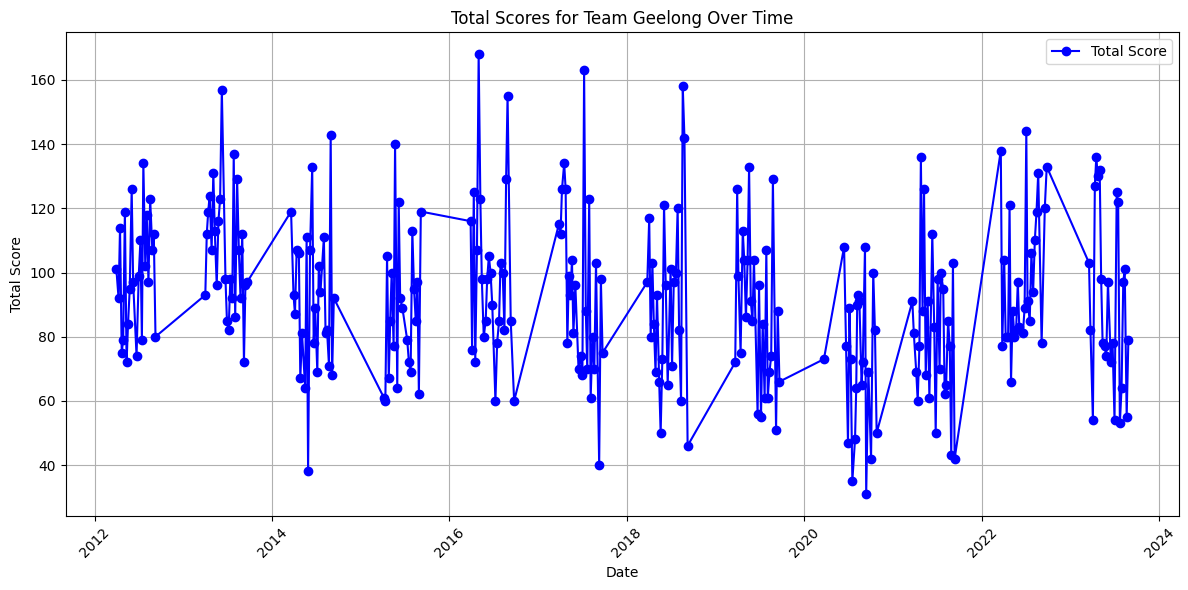

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Team Geelong's matches
geelong_data = data[(data['HomeTeam'] == 'Geelong') | (data['AwayTeam'] == 'Geelong')]

# Create a new column for the total score of Geelong in each match
geelong_data['Geelong_Score'] = geelong_data.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Geelong' else row['AwayTeamScore'], axis=1)

# Create a plot for Geelong's total scores
plt.figure(figsize=(12, 6))
plt.plot(geelong_data['Date'], geelong_data['Geelong_Score'], marker='o', color='blue', label='Total Score')
plt.title('Total Scores for Team Geelong Over Time')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


<ipython-input-68-a6c4cfeb557d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  collingwood_data['Collingwood_Score'] = geelong_data.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Collingwood' else row['AwayTeamScore'], axis=1)


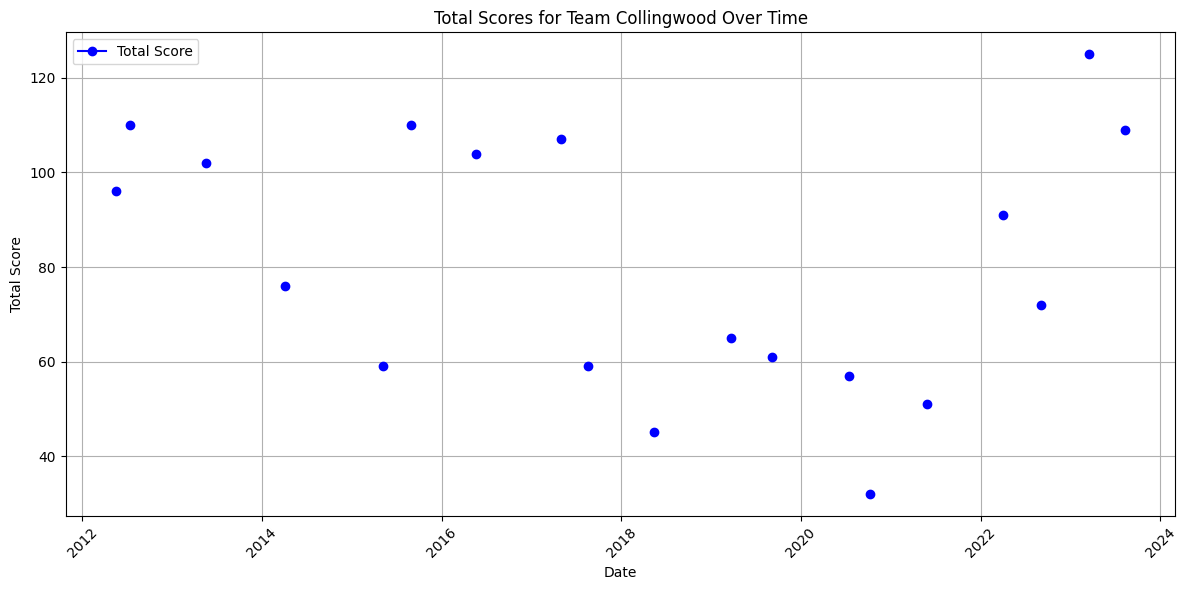

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for Team Collingwood's matches
collingwood_data = data[(data['HomeTeam'] == 'Collingwood') | (data['AwayTeam'] == 'Collingwood')]

# Create a new column for the total score of Collingwood in each match
collingwood_data['Collingwood_Score'] = geelong_data.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Collingwood' else row['AwayTeamScore'], axis=1)

# Create a plot for Collingwood's total scores
plt.figure(figsize=(12, 6))
plt.plot(collingwood_data['Date'], collingwood_data['Collingwood_Score'], marker='o', color='blue', label='Total Score')
plt.title('Total Scores for Team Collingwood Over Time')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<ipython-input-66-666b70750d55>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brisbane_vs_sydney['Brisbane_Score'] = brisbane_vs_sydney.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Brisbane Lions' else row['AwayTeamScore'], axis=1)
<ipython-input-66-666b70750d55>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brisbane_vs_sydney['Sydney_Score'] = brisbane_vs_sydney.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Sydney' else row['AwayTeamScore'], axis=1)


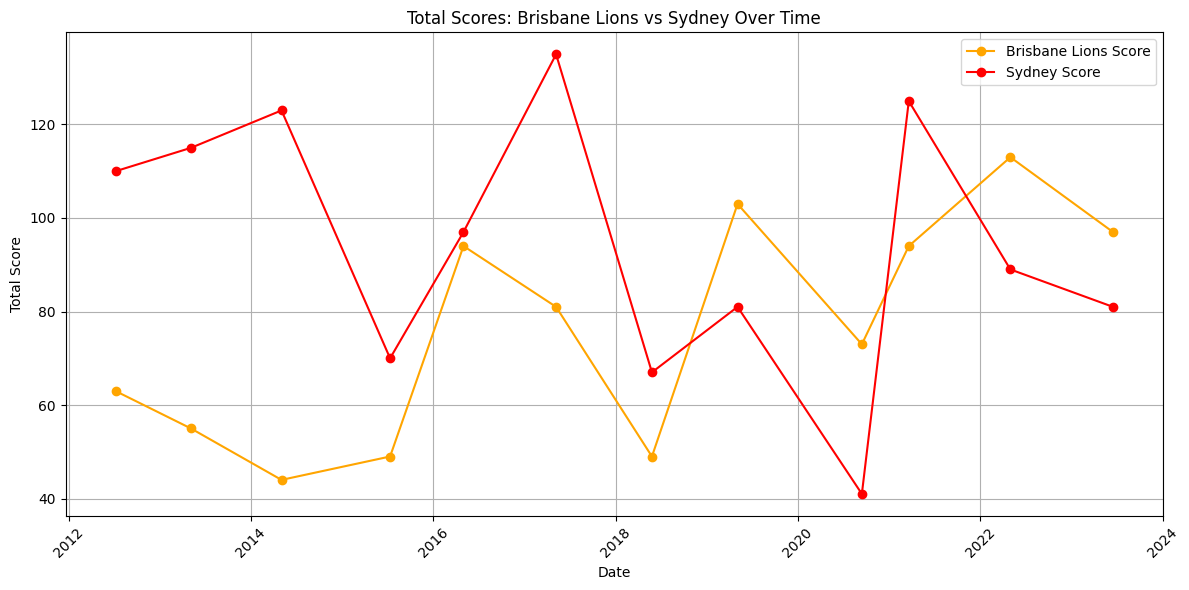

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for matches between Brisbane Lions and Sydney
brisbane_vs_sydney = data[((data['HomeTeam'] == 'Brisbane Lions') & (data['AwayTeam'] == 'Sydney')) |
                           ((data['HomeTeam'] == 'Sydney') & (data['AwayTeam'] == 'Brisbane Lions'))]

# Create a new column for each team's score
brisbane_vs_sydney['Brisbane_Score'] = brisbane_vs_sydney.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Brisbane Lions' else row['AwayTeamScore'], axis=1)
brisbane_vs_sydney['Sydney_Score'] = brisbane_vs_sydney.apply(lambda row: row['HomeTeamScore'] if row['HomeTeam'] == 'Sydney' else row['AwayTeamScore'], axis=1)

# Create a plot for Brisbane Lions and Sydney total scores
plt.figure(figsize=(12, 6))
plt.plot(brisbane_vs_sydney['Date'], brisbane_vs_sydney['Brisbane_Score'], marker='o', color='orange', label='Brisbane Lions Score')
plt.plot(brisbane_vs_sydney['Date'], brisbane_vs_sydney['Sydney_Score'], marker='o', color='red', label='Sydney Score')
plt.title('Total Scores: Brisbane Lions vs Sydney Over Time')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Attendance'] = data['Attendance'].str.replace(',', '').astype(float)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Define the date 6 months ago from the latest date in the dataset
six_months_ago = data['Date'].max() - timedelta(days=180)

# Filter data for the last 6 months
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points scored by the Home and Away teams in the last 6 months
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
#home_team_avg_points = ['HomeTeamScore'].mean() # This line was causing the error
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Map the calculated average points to the original dataset
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill missing values with 0 or another default value, if needed
data['HomeTeam_PastAvgPoints'].fillna(0, inplace=True)
data['AwayTeam_PastAvgPoints'].fillna(0, inplace=True)

data.head()

,GameId,Year,Round,Date,MaxTemp,MinTemp,Rainfall,Venue,StartTime,Attendance,...,HomeTeamScore,AwayTeam,AwayTeamScoreQT,AwayTeamScoreHT,AwayTeamScore3QT,AwayTeamScoreFT,AwayTeamScore,Win,HomeTeam_PastAvgPoints,AwayTeam_PastAvgPoints
0,2012R0101,2012,R1,2012-03-24,24.0,12.2,0.0,Stadium Australia,7:20 PM,38203.0,...,37,Sydney,4.1,8.4,13.80,14.16,100,0,96.000000,81.818182
1,2012R0102,2012,R1,2012-03-29,25.7,9.7,0.0,M.C.G.,7:45 PM,78285.0,...,81,Carlton,3.2,8.7,11.13,18.17,125,0,86.909091,84.916667
2,2012R0103,2012,R1,2012-03-30,27.4,9.7,0.0,M.C.G.,7:50 PM,78466.0,...,137,Collingwood,2.7,7.9,12.16,16.19,115,1,82.000000,87.700000
3,2012R0104,2012,R1,2012-03-31,29.1,15.1,0.6,M.C.G.,1:45 PM,33473.0,...,78,Brisbane Lions,1.4,7.8,13.13,17.17,119,0,83.900000,88.900000
4,2012R0105,2012,R1,2012-03-31,28.2,19.7,0.0,Carrara,3:45 PM,12790.0,...,68,Adelaide,7.8,11.1,15.16,19.23,137,0,86.777778,84.888889


In [ ]:
import numpy as np
#NumPy for Numerical Calculations
# Calculate median temperature
median_temp = np.median(data['MaxTemp'].dropna())
print(f'Median Maximum Temperature: {median_temp}')

# Calculate standard deviation of home team scores
std_home_scores = np.std(data['HomeTeamScore'])
print(f'Standard Deviation of Home Team Scores: {std_home_scores}')


Median Maximum Temperature: 18.5
Standard Deviation of Home Team Scores: 27.112366278200536


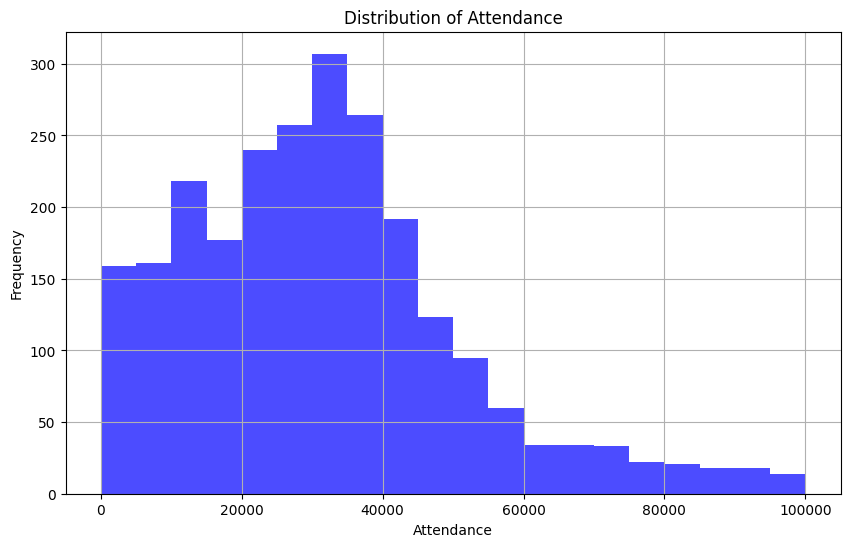

In [ ]:
#Matplotlib for Visualization
import matplotlib.pyplot as plt

# Plot a histogram of attendance
plt.figure(figsize=(10, 6))
plt.hist(data['Attendance'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Attendance')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid()
plt.show()


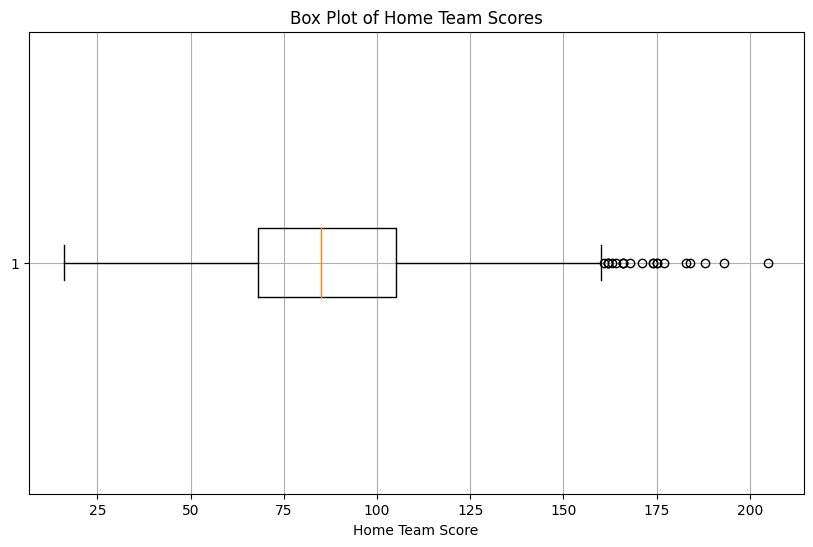

In [ ]:
# Box plot of home team scores
plt.figure(figsize=(10, 6))
plt.boxplot(data['HomeTeamScore'].dropna(), vert=False)
plt.title('Box Plot of Home Team Scores')
plt.xlabel('Home Team Score')
plt.grid()
plt.show()


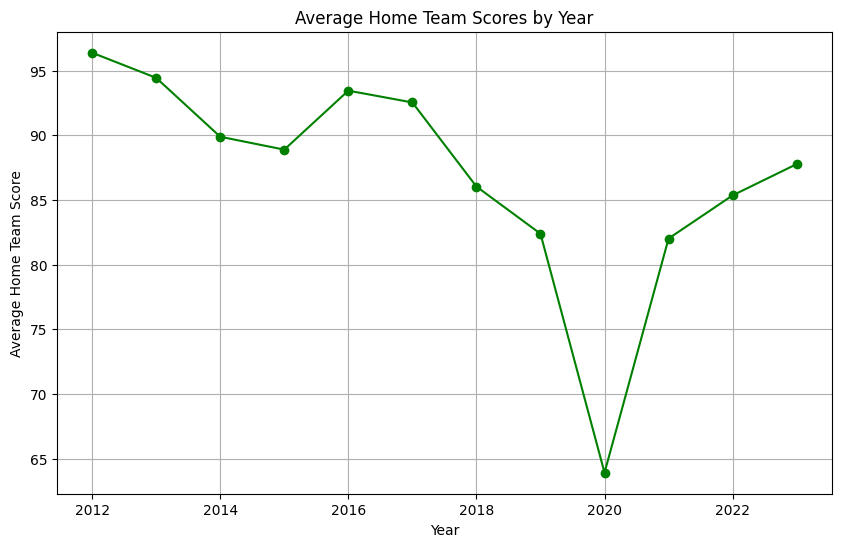

In [ ]:
# Line plot for average scores by year
average_scores_by_year = data.groupby('Year')['HomeTeamScore'].mean()
plt.figure(figsize=(10, 6))
average_scores_by_year.plot(kind='line', marker='o', color='green')
plt.title('Average Home Team Scores by Year')
plt.xlabel('Year')
plt.ylabel('Average Home Team Score')
plt.grid()
plt.show()


                            Year   MaxTemp   MinTemp  Rainfall  Attendance  \
Year                    1.000000  0.053414  0.056004  0.002570   -0.090029   
MaxTemp                 0.053414  1.000000  0.678767 -0.094905   -0.085308   
MinTemp                 0.056004  0.678767  1.000000  0.117724   -0.078417   
Rainfall                0.002570 -0.094905  0.117724  1.000000   -0.040401   
Attendance             -0.090029 -0.085308 -0.078417 -0.040401    1.000000   
HomeTeamScoreQT        -0.080399 -0.016446 -0.043822 -0.028593    0.034481   
HomeTeamScoreHT        -0.099225  0.006848 -0.056047 -0.048008    0.041845   
HomeTeamScore3QT       -0.115055  0.028852 -0.045456 -0.030214    0.058045   
HomeTeamScoreFT        -0.144165  0.035152 -0.053295 -0.039303    0.065129   
HomeTeamScore          -0.166230  0.030908 -0.052566 -0.043589    0.082908   
AwayTeamScoreQT        -0.070372  0.004051  0.023284 -0.028600    0.020516   
AwayTeamScoreHT        -0.102492  0.014134  0.013597 -0.016713  

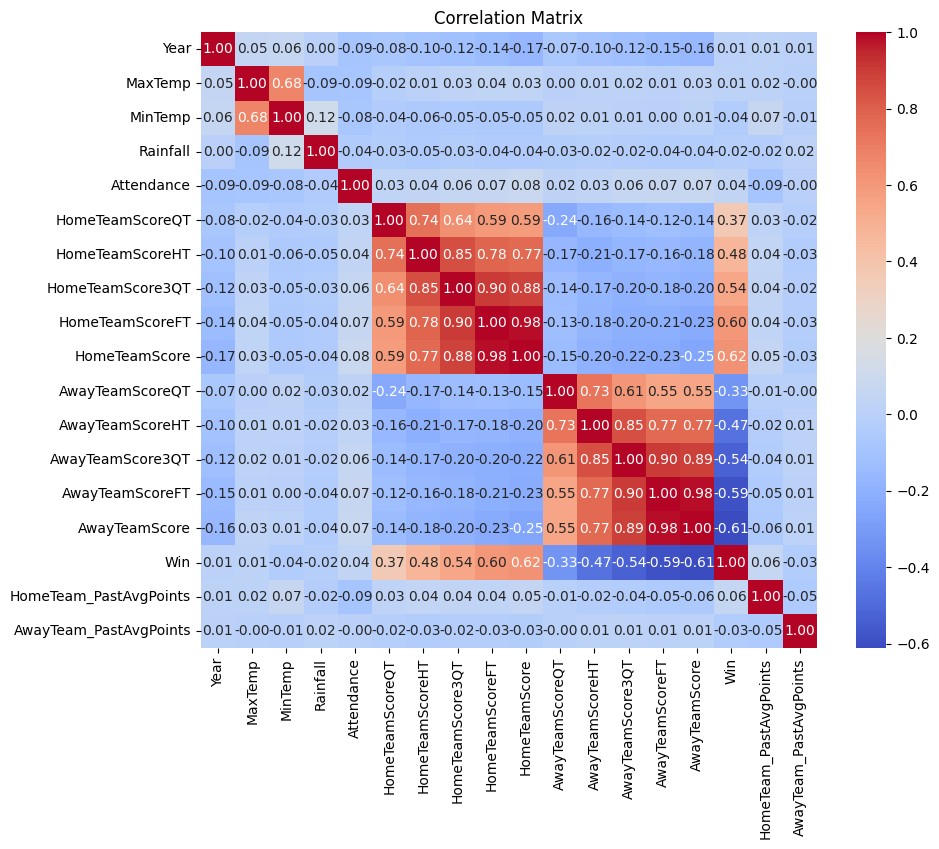

In [ ]:
import seaborn as sns

# Select only numeric columns from the DataFrame
numeric_data = data.select_dtypes(include=np.number)

# Calculate correlation matrix using only numeric columns
correlation_matrix = numeric_data.corr()
print(correlation_matrix)

# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


Win
1    0.562321
0    0.437679
Name: proportion, dtype: float64


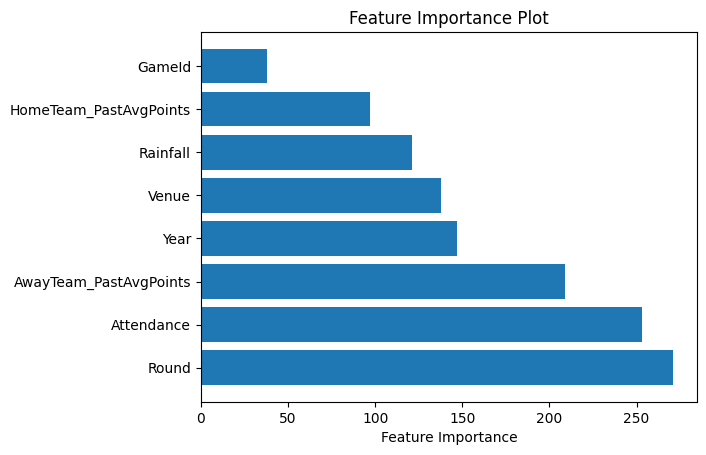

In [ ]:
# Check the distribution of the target variable
print(data['Win'].value_counts(normalize=True))

import matplotlib.pyplot as plt

# Get feature importance
importance = bst.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance see which Feature affect the model too much is never good?
plt.barh([x[0] for x in importance], [x[1] for x in importance])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


In [ ]:
# Features and target
X = data[['GameId','HomeTeam','Year','Rainfall','Venue','Round','Attendance','HomeTeam_PastAvgPoints',
          'AwayTeam','AwayTeam_PastAvgPoints']]
y = data['Win']
# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns

# Convert to categorical
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoostand Set up XGBoost parameters
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}
# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

<ipython-input-33-1d6fc0c77b1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-33-1d6fc0c77b1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-33-1d6fc0c77b1f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [ ]:

# Reset index of X_test and y_test to ensure alignment with y_pred
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create a copy of the test set and add predictions and the original 'Win' column
afl_data2 = X_test.copy()
afl_data2['Win'] = y_test
afl_data2['Predicted_Win'] = y_pred

# Print the new dataset with original and predicted values
print(afl_data2.head())

# Export the new dataset to a CSV file
afl_data2.to_csv('afl_data_predictions.csv', index=False)


      GameId                HomeTeam  Year  Rainfall           Venue Round  \
0   2022EF01          Brisbane Lions  2022       0.0           Gabba    EF   
1  2017R2306           Port Adelaide  2017       0.0   Adelaide Oval   R23   
2  2017R1509               Fremantle  2017      21.8         Subiaco   R15   
3  2021R1706  Greater Western Sydney  2021       0.2  Eureka Stadium   R17   
4  2016R0608                 Carlton  2016       9.8          M.C.G.    R6   

   Attendance  HomeTeam_PastAvgPoints    AwayTeam  AwayTeam_PastAvgPoints  \
0     35013.0              104.692308    Richmond               76.111111   
1     34288.0              100.090909  Gold Coast               76.727273   
2     30541.0               80.800000    St Kilda               76.272727   
3      2952.0               96.000000  Gold Coast               76.727273   
4     43827.0               81.000000    Essendon               68.777778   

   Win  Predicted_Win  
0    1              1  
1    1              

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

Accuracy: 0.6224
Confusion Matrix:
[[111 108]
 [ 77 194]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       219
           1       0.64      0.72      0.68       271

    accuracy                           0.62       490
   macro avg       0.62      0.61      0.61       490
weighted avg       0.62      0.62      0.62       490



In [ ]:
#without probability and use 6 months AVG of the score.
import pandas as pd
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Attendance'] = data['Attendance'].str.replace(',', '').astype(float)  # Replace commas before conversion

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Define the date 6 months ago from the latest date in the dataset
six_months_ago = data['Date'].max() - timedelta(days=180)

# Filter data for the last 6 months
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points scored by the Home and Away teams in the last 6 months
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Map the calculated average points to the original dataset
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill missing values with 0 or another default value, if needed
data['HomeTeam_PastAvgPoints'].fillna(0, inplace=True)
data['AwayTeam_PastAvgPoints'].fillna(0, inplace=True)

# Features and target - use specified features for prediction
X = data[['GameId', 'HomeTeam', 'Year', 'Rainfall', 'Venue', 'HomeTeam_PastAvgPoints', 'AwayTeam', 'AwayTeam_PastAvgPoints']]
y = data['Win']

# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# User Input for HomeTeam and AwayTeam
# Get unique teams for user selection
home_teams = data['HomeTeam'].unique()
away_teams = data['AwayTeam'].unique()

print("Available Home Teams:")
print(home_teams)

print("\nAvailable Away Teams:")
print(away_teams)

home_team = input("Select Home Team from the list above: ")
away_team = input("Select Away Team from the list above: ")

# Check if the selected teams are valid
if home_team not in home_teams or away_team not in away_teams:
    print("Invalid team selection. Please ensure you choose from the available teams.")
else:
    # Get the last average points for the selected teams
    last_home_avg_points = data[data['HomeTeam'] == home_team]['HomeTeam_PastAvgPoints'].iloc[-1]
    last_away_avg_points = data[data['AwayTeam'] == away_team]['AwayTeam_PastAvgPoints'].iloc[-1]

    # Create a new DataFrame for the prediction input
    new_data = pd.DataFrame({
        'GameId': ['2024R0110'],  # Placeholder for GameId
        'HomeTeam': [home_team],   # User-selected Home Team
        'Year': [2024],            # Fixed Year
        'Rainfall': [0],           # Fixed Rainfall
        'Venue': ['M.C.G.'],       # Fixed Venue
        'HomeTeam_PastAvgPoints': [last_home_avg_points],  # Last avg points
        'AwayTeam': [away_team],    # User-selected Away Team
        'AwayTeam_PastAvgPoints': [last_away_avg_points]   # Last avg points
    })

    # Convert object type columns to categorical in new_data
    for col in new_data.select_dtypes(include=['object']).columns:
        new_data[col] = new_data[col].astype('category')

    # Convert new_data to DMatrix format
    dnew = xgb.DMatrix(new_data, enable_categorical=True)

    # Predict the outcome for the selected teams
    new_pred_probs = bst.predict(dnew)
    new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

    # Print the prediction
    if new_pred[0] == 1:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
    else:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')



<ipython-input-1-0229cdb9161e>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['HomeTeam_PastAvgPoints'].fillna(0, inplace=True)
<ipython-input-1-0229cdb9161e>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Accuracy: 0.6245
Confusion Matrix:
[[ 99 120]
 [ 64 207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       219
           1       0.63      0.76      0.69       271

    accuracy                           0.62       490
   macro avg       0.62      0.61      0.61       490
weighted avg       0.62      0.62      0.61       490

Available Home Teams:
['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney' 'West Coast' 'Adelaide'
 'Collingwood' 'St Kilda' 'Geelong' 'Carlton']

Available Away Teams:
['Sydney' 'Carlton' 'Collingwood' 'Brisbane Lions' 'Adelaide' 'Geelong'
 'Essendon' 'West Coast' 'St Kilda' 'Port Adelaide' 'Fremantle'
 'Melbourne' 'Western Bulldogs' 'Richmond' 'Greater Western Sydney'
 'Gold Coast' 'Hawthorn' 'North Melbourne']
Select Home Team from the list above: Richmond
Sele

In [ ]:
#With posibility result
import pandas as pd
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Attendance'] = data['Attendance'].str.replace(',', '').astype(float)  # Replace commas before conversion

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Define the date 6 months ago from the latest date in the dataset
six_months_ago = data['Date'].max() - timedelta(days=180)

# Filter data for the last 6 months
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points scored by the Home and Away teams in the last 6 months
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Map the calculated average points to the original dataset
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill missing values with 0 or another default value, if needed
data['HomeTeam_PastAvgPoints'].fillna(0, inplace=True)
data['AwayTeam_PastAvgPoints'].fillna(0, inplace=True)

# Features and target - use specified features for prediction
X = data[['GameId', 'HomeTeam', 'Year', 'Rainfall', 'Venue', 'HomeTeam_PastAvgPoints', 'AwayTeam', 'AwayTeam_PastAvgPoints']]
y = data['Win']

# Check for class balance in the target variable
print("Class distribution in target variable:")
print(y.value_counts(normalize=True))

# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# User Input for HomeTeam and AwayTeam
# Get unique teams for user selection
home_teams = data['HomeTeam'].unique()
away_teams = data['AwayTeam'].unique()

print("Available Home Teams:")
print(home_teams)

print("\nAvailable Away Teams:")
print(away_teams)

home_team = input("Select Home Team from the list above: ")
away_team = input("Select Away Team from the list above: ")

# Check if the selected teams are valid
if home_team not in home_teams or away_team not in away_teams:
    print("Invalid team selection. Please ensure you choose from the available teams.")
else:
    # Get the last average points for the selected teams
    last_home_avg_points = data[data['HomeTeam'] == home_team]['HomeTeam_PastAvgPoints'].iloc[-1]
    last_away_avg_points = data[data['AwayTeam'] == away_team]['AwayTeam_PastAvgPoints'].iloc[-1]

    # Create a new DataFrame for the prediction input
    new_data = pd.DataFrame({
        'GameId': ['2024R0110'],  # Placeholder for GameId
        'HomeTeam': [home_team],   # User-selected Home Team
        'Year': [2024],            # Fixed Year
        'Rainfall': [0],           # Fixed Rainfall
        'Venue': ['M.C.G.'],       # Fixed Venue
        'HomeTeam_PastAvgPoints': [last_home_avg_points],  # Last avg points
        'AwayTeam': [away_team],    # User-selected Away Team
        'AwayTeam_PastAvgPoints': [last_away_avg_points]   # Last avg points
    })

    # Convert object type columns to categorical in new_data
    for col in new_data.select_dtypes(include=['object']).columns:
        new_data[col] = new_data[col].astype('category')

    # Convert new_data to DMatrix format
    dnew = xgb.DMatrix(new_data, enable_categorical=True)

    # Predict the outcome for the selected teams
    new_pred_probs = bst.predict(dnew)
    new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

    # Print the prediction
    if new_pred[0] == 1:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
    else:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')

    # Display prediction probabilities for debugging
    print(f'Prediction probabilities - Home Win: {new_pred_probs[0]}, Away Win: {1 - new_pred_probs[0]}')


Class distribution in target variable:
Win
1    0.562321
0    0.437679
Name: proportion, dtype: float64


<ipython-input-17-5acc7f817b8a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-17-5acc7f817b8a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-17-5acc7f817b8a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Accuracy: 0.6245
Confusion Matrix:
[[ 99 120]
 [ 64 207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       219
           1       0.63      0.76      0.69       271

    accuracy                           0.62       490
   macro avg       0.62      0.61      0.61       490
weighted avg       0.62      0.62      0.61       490

Available Home Teams:
['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney' 'West Coast' 'Adelaide'
 'Collingwood' 'St Kilda' 'Geelong' 'Carlton']

Available Away Teams:
['Sydney' 'Carlton' 'Collingwood' 'Brisbane Lions' 'Adelaide' 'Geelong'
 'Essendon' 'West Coast' 'St Kilda' 'Port Adelaide' 'Fremantle'
 'Melbourne' 'Western Bulldogs' 'Richmond' 'Greater Western Sydney'
 'Gold Coast' 'Hawthorn' 'North Melbourne']
Select Home Team from the list above: Collingwood
S

In [10]:
#final work
import pandas as pd
from datetime import timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the last 6 months
six_months_ago = data['Date'].max() - timedelta(days=180)
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points for home and away teams
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Use the .map() method and assign to avoid chained assignment issues
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill NaN values
data['HomeTeam_PastAvgPoints'] = data['HomeTeam_PastAvgPoints'].fillna(0)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam_PastAvgPoints'].fillna(0)

# Print class distribution
print("Class distribution in target variable:")
print(data['Win'].value_counts(normalize=True))

# Feature selection
X = data[['HomeTeam', 'Year', 'Rainfall', 'Venue', 'HomeTeam_PastAvgPoints', 'AwayTeam', 'AwayTeam_PastAvgPoints']]
y = data['Win']

# Encode categorical features
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Feature importance
importance = bst.get_score(importance_type='weight')
print("Feature importance:")
print(importance)

# User input for prediction
home_teams = data['HomeTeam'].unique()
away_teams = data['AwayTeam'].unique()

print("Available Home Teams:")
print(home_teams)

print("\nAvailable Away Teams:")
print(away_teams)

home_team = input("Select Home Team from the list above: ")
away_team = input("Select Away Team from the list above: ")

if home_team not in home_teams or away_team not in away_teams:
    print("Invalid team selection. Please ensure you choose from the available teams.")
else:
    # Get average points, handling cases where there might be NaN values
    last_home_avg_points = home_team_avg_points.get(home_team, 0)
    last_away_avg_points = away_team_avg_points.get(away_team, 0)

    # Create a DataFrame for prediction input
    new_data = pd.DataFrame({
        'HomeTeam': [home_team],
        'Year': [2024],
        'Rainfall': [0],
        'Venue': ['M.C.G.'],
        'HomeTeam_PastAvgPoints': [last_home_avg_points],
        'AwayTeam': [away_team],
        'AwayTeam_PastAvgPoints': [last_away_avg_points]
    })

    # Encode the categorical features in new_data using the previously fitted label encoders
    for col, le in label_encoders.items():
        new_data[col] = le.transform(new_data[col])

    # Prepare data for prediction
    dnew = xgb.DMatrix(new_data)

    # Make prediction
    new_pred_probs = bst.predict(dnew)
    new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

    # Output the result
    if new_pred[0] == 1:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
    else:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')

    # Display prediction probabilities for debugging
    print(f'Prediction probabilities - Home Win: {new_pred_probs[0]}, Away Win: {1 - new_pred_probs[0]}')

<ipython-input-10-b52e5b40177a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-10-b52e5b40177a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-10-b52e5b40177a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Class distribution in target variable:
Win
1    0.562321
0    0.437679
Name: proportion, dtype: float64
Feature importance:
{'HomeTeam': 127.0, 'Year': 274.0, 'Rainfall': 236.0, 'Venue': 125.0, 'HomeTeam_PastAvgPoints': 145.0, 'AwayTeam': 215.0, 'AwayTeam_PastAvgPoints': 156.0}
Available Home Teams:
['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney' 'West Coast' 'Adelaide'
 'Collingwood' 'St Kilda' 'Geelong' 'Carlton']

Available Away Teams:
['Sydney' 'Carlton' 'Collingwood' 'Brisbane Lions' 'Adelaide' 'Geelong'
 'Essendon' 'West Coast' 'St Kilda' 'Port Adelaide' 'Fremantle'
 'Melbourne' 'Western Bulldogs' 'Richmond' 'Greater Western Sydney'
 'Gold Coast' 'Hawthorn' 'North Melbourne']
Select Home Team from the list above: Adelaide
Select Away Team from the list above: Western Bulldogs
The predicted outcome for Adelaide vs Western Bulldogs is: Adelaide will WIN.


In [11]:
import pandas as pd
from datetime import timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the last 6 months
six_months_ago = data['Date'].max() - timedelta(days=180)
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points for home and away teams
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Use the .map() method and assign to avoid chained assignment issues
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill NaN values
data['HomeTeam_PastAvgPoints'] = data['HomeTeam_PastAvgPoints'].fillna(0)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam_PastAvgPoints'].fillna(0)

# Print class distribution
print("Class distribution in target variable:")
print(data['Win'].value_counts(normalize=True))

# Feature selection
X = data[['HomeTeam', 'Year', 'Rainfall', 'Venue', 'HomeTeam_PastAvgPoints', 'AwayTeam', 'AwayTeam_PastAvgPoints']]
y = data['Win']

# Encode categorical features
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Define Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the best model with the optimal parameters
best_xgb = grid_search.best_estimator_

# Feature importance
importance = best_xgb.feature_importances_
print("Feature importance:")
for i, col in enumerate(X.columns):
    print(f"{col}: {importance[i]}")

# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# User input for prediction
home_teams = data['HomeTeam'].unique()
away_teams = data['AwayTeam'].unique()

print("Available Home Teams:")
print(home_teams)

print("\nAvailable Away Teams:")
print(away_teams)

home_team = input("Select Home Team from the list above: ")
away_team = input("Select Away Team from the list above: ")

if home_team not in home_teams or away_team not in away_teams:
    print("Invalid team selection. Please ensure you choose from the available teams.")
else:
    # Get average points, handling cases where there might be NaN values
    last_home_avg_points = home_team_avg_points.get(home_team, 0)
    last_away_avg_points = away_team_avg_points.get(away_team, 0)

    # Create a DataFrame for prediction input
    new_data = pd.DataFrame({
        'HomeTeam': [home_team],
        'Year': [2024],
        'Rainfall': [0],
        'Venue': ['M.C.G.'],
        'HomeTeam_PastAvgPoints': [last_home_avg_points],
        'AwayTeam': [away_team],
        'AwayTeam_PastAvgPoints': [last_away_avg_points]
    })

    # Encode the categorical features in new_data using the previously fitted label encoders
    for col, le in label_encoders.items():
        new_data[col] = le.transform(new_data[col])

    # Make prediction with the best model
    new_pred_probs = best_xgb.predict_proba(new_data)[:, 1]
    new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

    # Output the result
    if new_pred[0] == 1:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
    else:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')

    # Display prediction probabilities for debugging
    print(f'Prediction probabilities - Home Win: {new_pred_probs[0]}, Away Win: {1 - new_pred_probs[0]}')


Class distribution in target variable:
Win
1    0.562321
0    0.437679
Name: proportion, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits


<ipython-input-11-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-11-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-11-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Feature importance:
HomeTeam: 0.12399479746818542
Year: 0.15539324283599854
Rainfall: 0.11016083508729935
Venue: 0.15301993489265442
HomeTeam_PastAvgPoints: 0.16078796982765198
AwayTeam: 0.1367177963256836
AwayTeam_PastAvgPoints: 0.15992537140846252
Accuracy on test set: 0.6326530612244898

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       219
           1       0.64      0.77      0.70       271

    accuracy                           0.63       490
   macro avg       0.63      0.62      0.61       490
weighted avg       0.63      0.63      0.62       490


Confusion Matrix:
 [[100 119]
 [ 61 210]]
Available Home Teams:
['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney

In [1]:
import pandas as pd
from datetime import timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the last 6 months
six_months_ago = data['Date'].max() - timedelta(days=180)
data_last_6_months = data[data['Date'] >= six_months_ago]

# Calculate average points for home and away teams
home_team_avg_points = data_last_6_months.groupby('HomeTeam')['HomeTeamScore'].mean()
away_team_avg_points = data_last_6_months.groupby('AwayTeam')['AwayTeamScore'].mean()

# Use the .map() method and assign to avoid chained assignment issues
data['HomeTeam_PastAvgPoints'] = data['HomeTeam'].map(home_team_avg_points)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam'].map(away_team_avg_points)

# Fill NaN values
data['HomeTeam_PastAvgPoints'] = data['HomeTeam_PastAvgPoints'].fillna(0)
data['AwayTeam_PastAvgPoints'] = data['AwayTeam_PastAvgPoints'].fillna(0)

# Print class distribution
print("Class distribution in target variable:")
print(data['Win'].value_counts(normalize=True))

# Feature selection
X = data[['HomeTeam', 'Year', 'Rainfall', 'Venue', 'HomeTeam_PastAvgPoints', 'AwayTeam', 'AwayTeam_PastAvgPoints']]
y = data['Win']

# Encode categorical features
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

# Define Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Train the best model with the optimal parameters
best_xgb = grid_search.best_estimator_

# Feature importance
importance = best_xgb.feature_importances_
print("Feature importance:")
for i, col in enumerate(X.columns):
    print(f"{col}: {importance[i]}")

# Evaluate the model on the test set
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# User input for prediction
home_teams = data['HomeTeam'].unique()
away_teams = data['AwayTeam'].unique()

print("Available Home Teams:")
print(home_teams)

print("\nAvailable Away Teams:")
print(away_teams)

home_team = input("Select Home Team from the list above: ")
away_team = input("Select Away Team from the list above: ")

if home_team not in home_teams or away_team not in away_teams:
    print("Invalid team selection. Please ensure you choose from the available teams.")
else:
    # Get average points, handling cases where there might be NaN values
    last_home_avg_points = home_team_avg_points.get(home_team, 0)
    last_away_avg_points = away_team_avg_points.get(away_team, 0)

    # Create a DataFrame for prediction input
    new_data = pd.DataFrame({
        'HomeTeam': [home_team],
        'Year': [2024],
        'Rainfall': [0],
        'Venue': ['M.C.G.'],
        'HomeTeam_PastAvgPoints': [last_home_avg_points],
        'AwayTeam': [away_team],
        'AwayTeam_PastAvgPoints': [last_away_avg_points]
    })

    # Encode the categorical features in new_data using the previously fitted label encoders
    for col, le in label_encoders.items():
        new_data[col] = le.transform(new_data[col])

    # Make prediction with the best model
    new_pred_probs = best_xgb.predict_proba(new_data)[:, 1]
    new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

    # Output the result
    if new_pred[0] == 1:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
    else:
        print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')

    # Display prediction probabilities for debugging
    print(f'Prediction probabilities - Home Win: {new_pred_probs[0]}, Away Win: {1 - new_pred_probs[0]}')


Class distribution in target variable:
Win
1    0.562321
0    0.437679
Name: proportion, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits


<ipython-input-1-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-1-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-1-ed8a55d9b7ea>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Best parameters found:  {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Feature importance:
HomeTeam: 0.12399479746818542
Year: 0.15539324283599854
Rainfall: 0.11016083508729935
Venue: 0.15301993489265442
HomeTeam_PastAvgPoints: 0.16078796982765198
AwayTeam: 0.1367177963256836
AwayTeam_PastAvgPoints: 0.15992537140846252
Accuracy on test set: 0.6326530612244898

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       219
           1       0.64      0.77      0.70       271

    accuracy                           0.63       490
   macro avg       0.63      0.62      0.61       490
weighted avg       0.63      0.63      0.62       490


Confusion Matrix:
 [[100 119]
 [ 61 210]]
Available Home Teams:
['Greater Western Sydney' 'Richmond' 'Hawthorn' 'Melbourne' 'Gold Coast'
 'Fremantle' 'North Melbourne' 'Western Bulldogs' 'Port Adelaide'
 'Brisbane Lions' 'Essendon' 'Sydney